# Reducing Bias in Machine Learning Models:
### Modeling Part 1: Vanilla Models (Basic and Optimized)


#### Kristen Lo - BrainStation
---

### Table of Contents
- [Introduction](#intro)
- [Part 3: Vanilla Models (Basic and Optimized)](#clean)
    - 1.1: [Housekeeping](#house)
    - 1.2: [Pre-processing Demographic Data](#demo)
    - 1.3: [Pre-processing Triage Numerical Data](#num)
    - 1.4: [Pre-processing Hospital Usage Data](#huse)
    - 1.5: [Pre-processing Historical Lab Data](#lab) 
    - 1.6: [Pre-processing Meds Data](#med) 
- [Conclusion](#conc)


---
### <a id = 'intro'></a> Introduction

In this notebook, we will be preparing our vanilla model and then optimizing it for performance. 

There is a need to be able to predict the hospital admission rates for diabetic patients. However, using traditional machine learning models can lead to health disparities caused by biased data which can be related to demographic data (ex. race, age, income, insurance etc). These biases need to be removed prior to modelling so that bias isn't introduced into the model. Building on the work of Raza, S. who aimed to predict, diagnose, and mitigate health disparities in hospital re-admission, my aim is to replicate the study performed by Raza and create my own model that's able to screen for biases and predict admission rates for diabetics visiting the ER. 


Data was sourced from all adult Emergency Department visits from March 2014 - July 2017 from one academic and two community emergency rooms, apart from the Yale New Haven Health system. These visits resulted in either admission to their respective hospital or discharge. 

There are a total of 972 variables that we extracted per patient visit from 560,486 patient visits. 

Courtesy of:
 "Hong WS, Haimovich AD, Taylor RA (2018) Predicting hospital admission at emergency department triage using machine learning. PLoS ONE 13(7): e0201016." (https://doi.org/10.1371/journal.pone.0201016)




-----

## <a id = 'clean'></a> Part 3: Vanilla Modelling (Basic and Optimized) 

---
#### <a id = 'housekeeping'></a> 1.1 HouseKeeping 

Loading the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

Loading the clean csv file

In [2]:
health_data = pd.read_csv('Data/clean_health_data_pt2.csv')

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None) #Show all rows

In [4]:
health_data.head()

,demo_gender,demo_race,disposition,pmh_2ndarymalig,pmh_abdomhernia,pmh_acqfootdef,pmh_acrenlfail,pmh_acutecvd,pmh_acutemi,pmh_acutphanm,pmh_adltrespfl,pmh_alcoholrelateddisorders,pmh_amniosdx,pmh_anemia,pmh_aneurysm,pmh_anxietydisorders,pmh_artembolism,pmh_asppneumon,pmh_asthma,pmh_attentiondeficitconductdisruptivebeha,pmh_biliarydx,pmh_bladdercncr,pmh_blindness,pmh_bnignutneo,pmh_bonectcncr,pmh_bph,pmh_brainnscan,pmh_breastcancr,pmh_breastdx,pmh_brnchlngca,pmh_cardiaarrst,pmh_carditis,pmh_cataract,pmh_chfnonhp,pmh_chrkidneydisease,pmh_coaghemrdx,pmh_coloncancer,pmh_comabrndmg,pmh_complicdevi,pmh_complicproc,pmh_conduction,pmh_contraceptiv,pmh_copd,pmh_coronathero,pmh_crushinjury,pmh_cysticfibro,pmh_deliriumdementiaamnesticothercognitiv,pmh_developmentaldisorders,pmh_diabmelnoc,pmh_diabmelwcm,pmh_disordersusuallydiagnosedininfancych,pmh_diverticulos,pmh_dizziness,pmh_dminpreg,pmh_dysrhythmia,pmh_ecodesadverseeffectsofmedicalcare,pmh_ecodesfall,pmh_ecodesfirearm,pmh_ecodesmotorvehicletrafficmvt,pmh_ecodesotherspecifiedandclassifiable,pmh_encephalitis,pmh_endometrios,pmh_epilepsycnv,pmh_esophcancer,pmh_esophgealdx,pmh_eyeinfectn,pmh_femgenitca,pmh_feminfertil,pmh_fluidelcdx,pmh_fuo,pmh_fxarm,pmh_fxhip,pmh_fxskullfac,pmh_gangrene,pmh_gasduoulcer,pmh_gastritis,pmh_gastroent,pmh_giconganom,pmh_gihemorrhag,pmh_giperitcan,pmh_glaucoma,pmh_goutotcrys,pmh_guconganom,pmh_hdnckcancr,pmh_headachemig,pmh_hemorrpreg,pmh_hodgkinsds,pmh_hrtvalvedx,pmh_htn,pmh_htncomplicn,pmh_htninpreg,pmh_hyperlipidem,pmh_immunitydx,pmh_inducabortn,pmh_infectarth,pmh_influenza,pmh_infmalegen,pmh_intestinfct,pmh_intobstruct,pmh_intracrninj,pmh_jointinjury,pmh_kidnyrnlca,pmh_lateeffcvd,pmh_leukemias,pmh_liveribdca,pmh_lowbirthwt,pmh_lungexternl,pmh_lymphenlarg,pmh_maintchemr,pmh_maligneopls,pmh_meningitis,pmh_menstrualdx,pmh_miscellaneousmentalhealthdisorders,pmh_mooddisorders,pmh_mouthdx,pmh_ms,pmh_multmyeloma,pmh_mycoses,pmh_neoplsmunsp,pmh_nephritis,pmh_nonepithca,pmh_nonhodglym,pmh_nutritdefic,pmh_opnwndextr,pmh_osteoarthros,pmh_osteoporosis,pmh_otaftercare,pmh_otbnignneo,pmh_otbonedx,pmh_otcirculdx,pmh_otcomplbir,pmh_otconntiss,pmh_otdxbladdr,pmh_otdxkidney,pmh_otdxstomch,pmh_otendodsor,pmh_otfemalgen,pmh_othbactinf,pmh_othcnsinfx,pmh_othematldx,pmh_othercvd,pmh_othereardx,pmh_otheredcns,pmh_othereyedx,pmh_othergidx,pmh_othergudx,pmh_otherinjury,pmh_otherpregnancyanddeliveryincludingnormal,pmh_otherscreen,pmh_othfracture,pmh_othheartdx,pmh_othliverdx,pmh_othlowresp,pmh_othmalegen,pmh_othnervdx,pmh_othveindx,pmh_otinflskin,pmh_otitismedia,pmh_otjointdx,pmh_otnutritdx,pmh_otprimryca,pmh_otrespirca,pmh_otupprresp,pmh_otuprspin,pmh_ovariancyst,pmh_pancreascan,pmh_pancreasdx,pmh_paralysis,pmh_parkinsons,pmh_pathologfx,pmh_peripathero,pmh_peritonitis,pmh_personalitydisorders,pmh_phlebitis,pmh_pid,pmh_pleurisy,pmh_pneumonia,pmh_poisnotmed,pmh_precereoccl,pmh_prevcsectn,pmh_prolapse,pmh_prostatecan,pmh_pulmhartdx,pmh_rctmanusca,pmh_rehab,pmh_respdistres,pmh_retinaldx,pmh_rheumarth,pmh_schizophreniaandotherpsychoticdisorde,pmh_screeningandhistoryofmentalhealthan,pmh_septicemia,pmh_sexualinfxs,pmh_shock,pmh_sicklecell,pmh_skininfectn,pmh_skinmelanom,pmh_socialadmin,pmh_spincorinj,pmh_stomchcancr,pmh_substancerelateddisorders,pmh_suicideandintentionalselfinflictedin,pmh_superficinj,pmh_syncope,pmh_teethdx,pmh_testiscancr,pmh_thyroiddsor,pmh_tia,pmh_tonsillitis,pmh_ulceratcol,pmh_ulcerskin,pmh_unclassified,pmh_urinyorgca,pmh_uteruscancr,pmh_uti,pmh_varicosevn,pmh_viralinfect,pmh_whtblooddx,cc_abdominalcramping,cc_abdominaldistention,cc_abdominalpain,cc_abdominalpainpregnant,cc_abnormallab,cc_abscess,cc_addictionproblem,cc_alcoholintoxication,cc_alcoholproblem,cc_allergicreaction,cc_alteredmentalstatus,cc_animalbite,cc_ankleinjury,cc_anklepain,cc_anxiety,cc_arminjury,cc_armpain,cc_assaultvictim,cc_asthma,cc_backpain,cc_bleeding/bruising,cc_bodyfluidexposure,cc_breastpain,cc_breathingdifficulty,cc_burn,cc_cardiacarrest,cc_chestpain,cc_coldlikesymptoms,cc_confusion,cc_co

In [5]:
health_data.shape

(105627, 443)

In [9]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int64(443)
memory usage: 357.0 MB


Considering that all of the information is binary, int64 dtype is bloating the file unnecessarily. Let's convert it to int8 to conserve memory and assist in modeling.

In [10]:
# Assuming df is your DataFrame
int64_columns = health_data.select_dtypes(include='int64').columns

# Convert selected columns to int8
health_data[int64_columns] = health_data[int64_columns].astype('int8')

In [11]:
health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105627 entries, 0 to 105626
Columns: 443 entries, demo_gender to dum_huse__3-plus_hormones
dtypes: int8(443)
memory usage: 44.6 MB


As we can see, the memory usage has decreased from 357 mb to 44.6mb. This should be less computationally intensive.

I will be making two data frames to test. One will the original health_data frame as it is. The other data frame will be health_data_no_impute which will have all of the rows where data was imputed removed. We will create baseline vanilla models on both and assess accuracy. 

In [12]:
# Identify columns ending with '_imputed_flag'
imputed_flag_columns = health_data.filter(like='_imputed_flag').columns

# Count the number of rows with 1 in imputed flag columns
rows_with_1 = (health_data[imputed_flag_columns] == 1).any(axis=1).sum()

# Print the result
print(f"Number of rows with 1 in imputed flag columns: {rows_with_1}")


Number of rows with 1 in imputed flag columns: 68092


In [13]:
# Drop both rows and columns
health_data_no_impute = health_data.drop(columns=imputed_flag_columns)[~(health_data[imputed_flag_columns] == 1).any(axis=1)]

In [14]:
health_data_no_impute.shape

(37535, 437)

---
#### <a id = 'van'></a> 1.2 Logistic Regression and Decision Tree

Given that all of the data contained in the dataframe is binary (either 1 or 0), I think a suitable vanilla model to use would be Logistic regression and decision tree. 

I will first just run the model as is, making sure to split the train/test data, scaling it and then evaluating the performance.

 I will then run a pipeline and try to optimize for hyperparameters and see if it's possible to increase the accuracy of the model. 

First, I will just do some quick evaluations before building the models. I first want to test for multicolinearity and also cross-validation 

In [22]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Split to train/test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for multicollinearity
corr_matrix = X_train.corr()

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > 0.9)

# Show the highly correlated fatures
features_to_drop = set()
for col1, col2 in zip(*highly_correlated):
    if col1 != col2 and col1 not in features_to_drop:
        features_to_drop.add(col2)
        print(f"Highly correlated features: {X_train.columns[col1]} and {X_train.columns[col2]}")


Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_sbp_imputed_flag
Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_dbp_imputed_flag
Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_rr_imputed_flag
Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_temp_imputed_flag


So there is multicolinearity that exists within the data set, but this is due to the imputed flags. For now, I will not remove them. I will now run a baseline logistic regression without any additional parameters or hyperparameters added to evaluate it's overall performance. 

Train Accuracy: 0.7945231417379676
Test Accuracy: 0.7964593392028779

Train Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82     45721
           1       0.80      0.74      0.77     38780

    accuracy                           0.79     84501
   macro avg       0.79      0.79      0.79     84501
weighted avg       0.79      0.79      0.79     84501


Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82     11348
           1       0.80      0.75      0.77      9778

    accuracy                           0.80     21126
   macro avg       0.80      0.79      0.79     21126
weighted avg       0.80      0.80      0.80     21126


Confusion Matrix (Test):
 [[9541 1807]
 [2493 7285]]


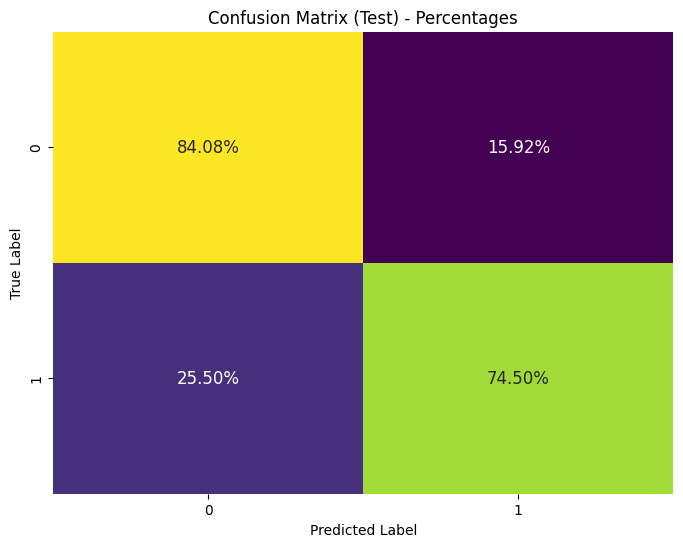

In [26]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  
logreg.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = logreg.predict(X_train_scaled)
y_test_pred = logreg.predict(X_test_scaled)

# Accuracy Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('Train Accuracy:', train_accuracy)
print('Test Accuracy:', test_accuracy)

# Classification Reports
print('\nTrain Classification Report:\n', classification_report(y_train, y_train_pred))
print('\nTest Classification Report:\n', classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print('\nConfusion Matrix (Test):\n', conf_matrix_test)

# Calculate percentages for the confusion matrix
conf_matrix_percent = conf_matrix_test / conf_matrix_test.sum(axis=1)[:, np.newaxis]

# Create a heatmap with the percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2%', cmap='viridis', cbar=False, annot_kws={'size': 12})
plt.title('Confusion Matrix (Test) - Percentages')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Train Accuracy: 0.7945, Test Accuracy: 0.7964
- The log model is achieving around 79.5% accuracy on the training set and 79.6% accuracy on the test set.
- The test accuracy is similar to the training accuracy, suggesting that the log model generalizes reasonably well to new, unseen data.

Train Classification Report:
- For class 0 (negative), precision is 79%, recall is 84%, and F1-score is 82%.
    - Class 0 (Negative Class):
        - Precision (79%): Out of all instances predicted as Class 0, 79% were correctly predicted. This means the model has a relatively low rate of false positives for Class 0.
        - Recall (84%): Out of all actual instances of Class 0, the model correctly identified 84% of them. This indicates a good ability to capture actual negatives
        - F1-Score (82%): The F1-Score, which balances precision and recall, is 82%. This suggests a good overall performance for predicting instances of Class 0.
    - For Class 0, the model is slightly better at recall (capturing actual negatives) than precision (avoiding false positives).
- For class 1 (positive), precision is 80%, recall is 74%, and F1-score is 77%.
    - Class 1 (Positive Class):
        - Precision (80%): Out of all instances predicted as Class 1, 80% were correctly predicted. This means the model has a relatively low rate of false positives for Class 1.
        - Recall (74%): Out of all actual instances of Class 1, the model correctly identified 74% of them. This indicates a good ability to capture actual positives, although it's somewhat lower than Class 0.
        - F1-Score (77%): The F1-Score, which balances precision and recall, is 77%. This suggests a good overall performance for predicting instances of Class 1.
    - For Class 1, the model is slightly better at precision (avoiding false positives) than recall (capturing actual positives).


Confusion Matrix (Test):
- It indicates that the log model is performing well in correctly predicting both classes, but it has some false positives and false negatives.

The log model has a decent accuracy, but further analysis might be needed to understand and potentially improve its performance, especially in terms of reducing false positives and false negatives

In [21]:

# Assuming health_data is your DataFrame
subset_size = 10000  # Adjust the size based on your requirements
health_data_subset = health_data.sample(n=subset_size, random_state=42)

# Now you can use health_data_subset for further analysis

# Assuming health_data_subset is your sampled subset
X_subset = health_data_subset.drop(['disposition'], axis=1)
y_subset = health_data_subset['disposition']

# Split the subset to train/test 
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

# Scale the subset
scaler_subset = StandardScaler()
X_train_scaled_subset = scaler_subset.fit_transform(X_train_subset)
X_test_scaled_subset = scaler_subset.transform(X_test_subset)

# Iterate over different values of n_features_to_select_subset
for n_features_to_select_subset in [10, 20, 30]:
    # Run RFE on the subset
    logreg_subset = LogisticRegression(max_iter=1000)
    rfe_subset = RFE(logreg_subset, n_features_to_select=n_features_to_select_subset)
    X_train_rfe_subset = rfe_subset.fit_transform(X_train_scaled_subset, y_train_subset)

    # Transform the entire dataset with the RFE-selected features
    X_train_rfe = rfe_subset.transform(X_train_scaled)
    X_test_rfe = rfe_subset.transform(X_test_scaled)

    # Train your larger model (e.g., Logistic Regression)
    logreg_large = LogisticRegression(max_iter=1000)
    logreg_large.fit(X_train_rfe, y_train)

    # Make predictions and evaluate the model on the entire dataset
    y_test_pred_large = logreg_large.predict(X_test_rfe)
    accuracy_large = accuracy_score(y_test, y_test_pred_large)

    print(f"Number of Features Selected: {n_features_to_select_subset}")
    print("Accuracy:", accuracy_large)
    print("Selected Features:", X.columns[rfe_subset.support_])
    print("\n" + "="*40 + "\n")


Number of Features Selected: 10
Accuracy: 0.7423553914607592
Selected Features: Index(['cc_alcoholintoxication', 'cc_dentalpain', 'cc_footinjury',
       'cc_laceration', 'cc_medicationrefill',
       'triage_vital_temp_imputed_flag', 'dum_huse__No_prior_admis',
       'dum_huse__1-to-2_antihyperglycemics',
       'dum_huse__3-to-6_antihyperglycemics', 'dum_huse__1-to-2_hormones'],
      dtype='object')


Number of Features Selected: 20
Accuracy: 0.7570765880905046
Selected Features: Index(['demo_race', 'pmh_chrkidneydisease', 'cc_alcoholintoxication',
       'cc_alteredmentalstatus', 'cc_dentalpain', 'cc_extremitylaceration',
       'cc_footinjury', 'cc_laceration', 'cc_medicationrefill',
       'cc_motorvehiclecrash', 'cc_respiratorydistress', 'cc_ribpain',
       'cc_shortnessofbreath', 'cc_suture/stapleremoval',
       'cc_urinaryfrequency', 'triage_vital_temp_imputed_flag',
       'dum_huse__No_prior_admis', 'dum_huse__1-to-2_antihyperglycemics',
       'dum_huse__3-to-6_antihyper

In [ ]:
#  Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']
# Assuming X and y are your entire feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the entire dataset using the same scaler
X_train_scaled = scaler_subset.transform(X_train)
X_test_scaled = scaler_subset.transform(X_test)

# Transform the entire dataset with the RFE-selected features
X_train_rfe = rfe_subset.transform(X_train_scaled)
X_test_rfe = rfe_subset.transform(X_test_scaled)

# Train your larger model (e.g., Logistic Regression)
logreg_large = LogisticRegression(max_iter=1000)
logreg_large.fit(X_train_rfe, y_train)

# Make predictions and evaluate the model on the entire dataset
y_test_pred_large = logreg_large.predict(X_test_rfe)
accuracy_large = accuracy_score(y_test, y_test_pred_large)


In [ ]:
# Step 1: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Run RFE to select important features
logreg = LogisticRegression(max_iter=1000)
rfe = RFE(logreg, n_features_to_select=10)  # You can adjust the number of features to select
X_train_rfe = rfe.fit_transform(X_train_scaled, y_train)

# Get the selected feature names
selected_features = X.columns[rfe.support_]

# Step 3: Train Logistic Regression model with selected features
logreg.fit(X_train_rfe, y_train)

# Step 4: Transform the test set using the same selected features
X_test_rfe = X_test[selected_features]
X_test_rfe_scaled = scaler.transform(X_test_rfe)

# Step 5: Make predictions and evaluate the model
y_test_pred = logreg.predict(X_test_rfe_scaled)

# Accuracy Scores
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Classification Report
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
print("\nConfusion Matrix (Test):\n", conf_matrix_test)

# Additional Metrics
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test_rfe_scaled)[:, 1])

print("\nF1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, logreg.predict_proba(X_test_rfe_scaled)[:, 1])

# Visualize ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.6s
[Pipeline] ........ (step 2 of 2) Processing classifier, total=   3.5s

Logistic Regression Results:
Train Accuracy: 0.7945231417379676
Test Accuracy: 0.7964593392028779

Train Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82     45721
           1       0.80      0.74      0.77     38780

    accuracy                           0.79     84501
   macro avg       0.79      0.79      0.79     84501
weighted avg       0.79      0.79      0.79     84501


Test Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.82     11348
           1       0.80      0.75      0.77      9778

    accuracy                           0.80     21126
   macro avg       0.80      0.79      0.79     21126
weighted avg       0.80      0.80      0.80     21126


Confusion Matrix (Test) - Logistic Regressi

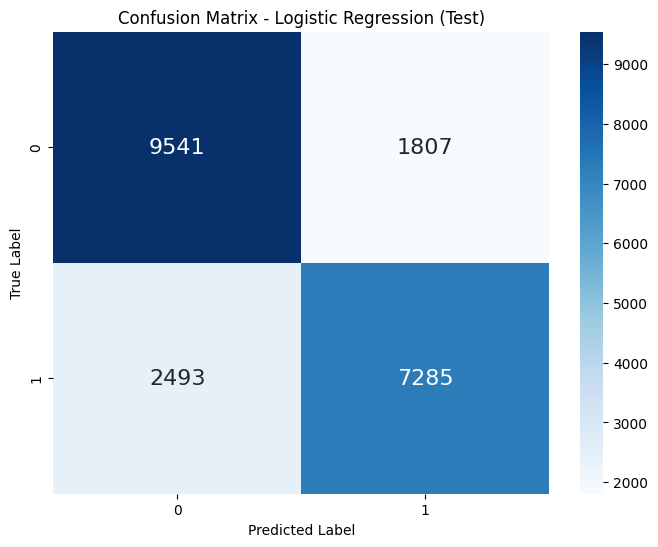


F1 Score - Logistic Regression: 0.7721250662427134
AUC-ROC Score - Logistic Regression: 0.8768351805571887


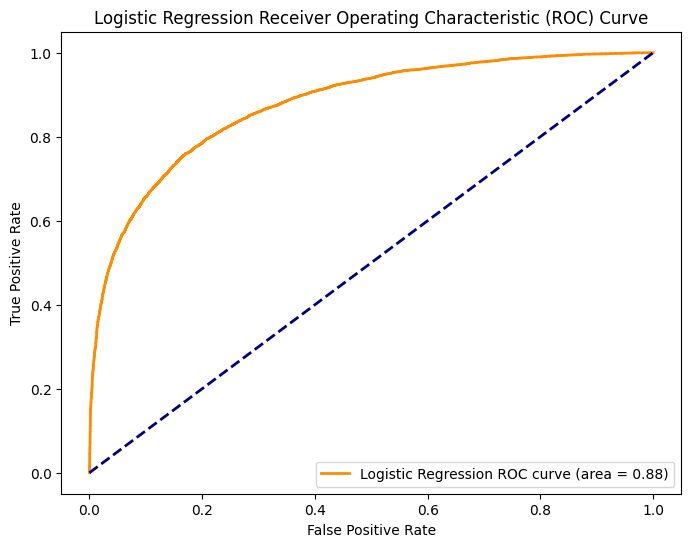

In [38]:
# Step 1: Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression Pipeline
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
], verbose=True)

# Decision Tree Pipeline
dt_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer(transformers=[('num', 'passthrough', X.columns)])),
    ('classifier', DecisionTreeClassifier())
])

# Fit and evaluate Logistic Regression
logreg_pipeline.fit(X_train, y_train)
y_train_pred_logreg = logreg_pipeline.predict(X_train)
y_test_pred_logreg = logreg_pipeline.predict(X_test)

# Accuracy Scores - Logistic Regression
train_accuracy_logreg = accuracy_score(y_train, y_train_pred_logreg)
test_accuracy_logreg = accuracy_score(y_test, y_test_pred_logreg)

# Print results for Logistic Regression
print("\nLogistic Regression Results:")
print("Train Accuracy:", train_accuracy_logreg)
print("Test Accuracy:", test_accuracy_logreg)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred_logreg))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_logreg))

# Confusion Matrix - Logistic Regression
conf_matrix_test_logreg = confusion_matrix(y_test, y_test_pred_logreg)
print("\nConfusion Matrix (Test) - Logistic Regression:\n", conf_matrix_test_logreg)

# Plot Confusion Matrix - Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_logreg, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.title('Confusion Matrix - Logistic Regression (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Additional Metrics - Logistic Regression
f1_logreg = f1_score(y_test, y_test_pred_logreg)
roc_auc_logreg = roc_auc_score(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])
print("\nF1 Score - Logistic Regression:", f1_logreg)
print("AUC-ROC Score - Logistic Regression:", roc_auc_logreg)

# ROC Curve - Logistic Regression
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_pipeline.predict_proba(X_test)[:, 1])

# Visualize ROC Curve - Logistic Regression
plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='darkorange', lw=2, label='Logistic Regression ROC curve (area = {:.2f})'.format(roc_auc_logreg))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



Decision Tree Results:
Train Accuracy: 0.9964024094389415
Test Accuracy: 0.7204392691470226

Train Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     45721
           1       1.00      0.99      1.00     38780

    accuracy                           1.00     84501
   macro avg       1.00      1.00      1.00     84501
weighted avg       1.00      1.00      1.00     84501


Test Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.75      0.74     11348
           1       0.70      0.69      0.70      9778

    accuracy                           0.72     21126
   macro avg       0.72      0.72      0.72     21126
weighted avg       0.72      0.72      0.72     21126


Confusion Matrix (Test) - Decision Tree:
 [[8471 2877]
 [3029 6749]]


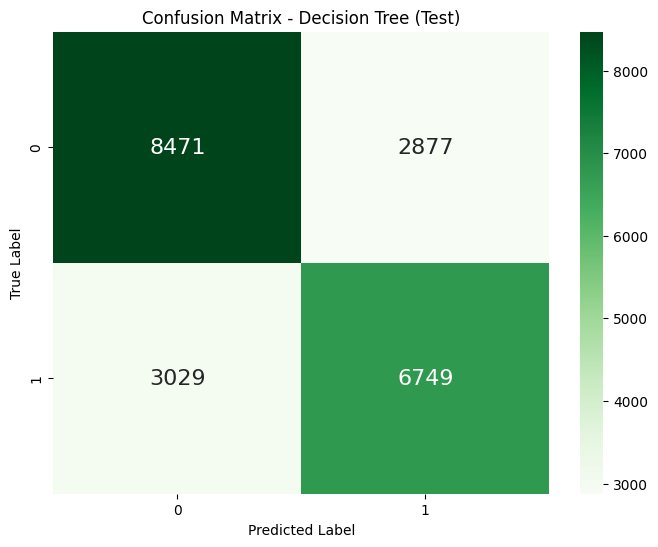


F1 Score - Decision Tree: 0.6956297670583385
AUC-ROC Score - Decision Tree: 0.7196094773841819


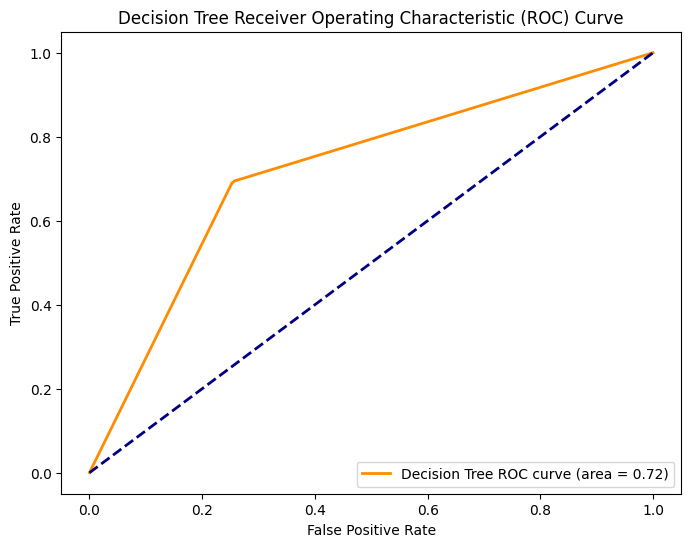

In [39]:
# Fit and evaluate Decision Tree
dt_pipeline.fit(X_train, y_train)
y_train_pred_dt = dt_pipeline.predict(X_train)
y_test_pred_dt = dt_pipeline.predict(X_test)

# Accuracy Scores - Decision Tree
train_accuracy_dt = accuracy_score(y_train, y_train_pred_dt)
test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)

# Print results for Decision Tree
print("\nDecision Tree Results:")
print("Train Accuracy:", train_accuracy_dt)
print("Test Accuracy:", test_accuracy_dt)
print("\nTrain Classification Report:\n", classification_report(y_train, y_train_pred_dt))
print("\nTest Classification Report:\n", classification_report(y_test, y_test_pred_dt))

# Confusion Matrix - Decision Tree
conf_matrix_test_dt = confusion_matrix(y_test, y_test_pred_dt)
print("\nConfusion Matrix (Test) - Decision Tree:\n", conf_matrix_test_dt)

# Plot Confusion Matrix - Decision Tree
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test_dt, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 16})
plt.title('Confusion Matrix - Decision Tree (Test)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Additional Metrics - Decision Tree
f1_dt = f1_score(y_test, y_test_pred_dt)
roc_auc_dt = roc_auc_score(y_test, dt_pipeline.predict_proba(X_test)[:, 1])
print("\nF1 Score - Decision Tree:", f1_dt)
print("AUC-ROC Score - Decision Tree:", roc_auc_dt)

# ROC Curve - Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, dt_pipeline.predict_proba(X_test)[:, 1])

# Visualize ROC Curve - Decision Tree
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label='Decision Tree ROC curve (area = {:.2f})'.format(roc_auc_dt))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [7]:
# Step 1: Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for multicollinearity
corr_matrix = X_train.corr()

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > 0.9)

# Drop one of the correlated features
features_to_drop = set()
for col1, col2 in zip(*highly_correlated):
    if col1 != col2 and col1 not in features_to_drop:
        features_to_drop.add(col2)
        print(f"Highly correlated features: {X_train.columns[col1]} and {X_train.columns[col2]}")


Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_sbp_imputed_flag
Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_dbp_imputed_flag
Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_rr_imputed_flag
Highly correlated features: triage_vital_hr_imputed_flag and triage_vital_temp_imputed_flag


In [ ]:

# Drop the features
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Step 1: Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']
# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check for multicollinearity
corr_matrix = X_train.corr()

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > 0.9)

# Drop one of the correlated features
features_to_drop = set()
for col1, col2 in zip(*highly_correlated):
    if col1 != col2 and col1 not in features_to_drop:
        features_to_drop.add(col2)

# Drop the features
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

# Continue with the rest of your code
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Create and train Logistic Regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Add a constant term to the features for the intercept
X_train_sm = sm.add_constant(X_train)

# Create and train Logistic Regression model with statsmodels
logreg_model_sm = sm.Logit(y_train, X_train_sm)
result = logreg_model_sm.fit()

# Extract coefficients, odds ratios, and p-values
coefficients = result.params
odds_ratios = np.exp(coefficients)
p_values = result.pvalues

# Create a DataFrame to display feature names, coefficients, odds ratios, and p-values
results_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients.values,
    'Odds Ratio': odds_ratios.values,
    'P-value': p_values.values
})

# Print or inspect the results
print("Feature, Coefficients, Odds Ratios, and P-values:")
print(results_df)


KeyError: '[392, 393, 394, 391] not found in axis'

In [29]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Step 1: Define the features and target variables
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Assuming X and y are your feature matrix and target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train LinearSVC model
svc_model = LinearSVC()
svc_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = svc_model.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

classification_rep = classification_report(y_test, y_pred)
print("Classification Report:\n", classification_rep)


/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Accuracy: 0.7787560352172678
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.82      0.80     11348
           1       0.78      0.73      0.75      9778

    accuracy                           0.78     21126
   macro avg       0.78      0.78      0.78     21126
weighted avg       0.78      0.78      0.78     21126



/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'health_data' is your DataFrame
# Replace 'y_column' with the actual target column name

# Step 1: Separate Features and Target
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Step 2: Train-Test Split (Using a smaller subset for demonstration)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Step 4: Hyperparameter Tuning with Simplified GridSearchCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:

# Simplified hyperparameter grid
param_grid = {'C': [0.1, 1], 'penalty': ['l2']}

grid_search = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Best hyperparameters
best_params = grid_search.best_params_


In [10]:

# Step 5: Model Training with Best Hyperparameters
best_model = LogisticRegression(max_iter=1000, **best_params)
best_model.fit(X_train_scaled, y_train)

# Step 6: Model Evaluation
X_test_scaled = scaler.transform(X_test)
y_pred = best_model.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Best Hyperparameters:", best_params)


Accuracy: 0.791867840575594
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11414
           1       0.79      0.74      0.77      9712

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2'}


In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'health_data' is your DataFrame
# Replace 'y_column' with the actual target column name

# Step 1: Separate Features and Target
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Step 2: Train-Test Split (Using a smaller subset for demonstration)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), X.columns)  # Scale all columns
    ],
    remainder='passthrough'
)

# Step 4: Create a pipeline for Logistic Regression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Step 5: Create a pipeline for Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Step 6: Hyperparameter Tuning with GridSearchCV for Logistic Regression
logreg_param_grid = {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'classifier__penalty': ['l2','l1']}
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
logreg_grid_search.fit(X_train, y_train)

# Best hyperparameters for Logistic Regression
logreg_best_params = logreg_grid_search.best_params_

# Step 7: Hyperparameter Tuning with GridSearchCV for Decision Tree
dt_param_grid = {'classifier__max_depth': [None, 5, 10, 15], 'classifier__min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

# Best hyperparameters for Decision Tree
dt_best_params = dt_grid_search.best_params_

# Step 8: Model Evaluation for Logistic Regression
logreg_best_model = logreg_grid_search.best_estimator_
y_logreg_pred = logreg_best_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_logreg_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_logreg_pred))
print("Logistic Regression Best Hyperparameters:", logreg_best_params)

# Step 9: Model Evaluation for Decision Tree
dt_best_model = dt_grid_search.best_estimator_
y_dt_pred = dt_best_model.predict(X_test)
print("\nDecision Tree Accuracy:", accuracy_score(y_test, y_dt_pred))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_dt_pred))
print("Decision Tree Best Hyperparameters:", dt_best_params)


/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
21 fits failed out of a total of 42.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/kristenlo/anaconda3/envs/klo-BS_HS-Bia/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/kristenl

Logistic Regression Accuracy: 0.7921045157625675
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11414
           1       0.79      0.74      0.77      9712

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126

Logistic Regression Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}

Decision Tree Accuracy: 0.7620941020543406
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80     11414
           1       0.82      0.62      0.71      9712

    accuracy                           0.76     21126
   macro avg       0.77      0.75      0.75     21126
weighted avg       0.77      0.76      0.76     21126

Decision Tree Best Hyperparameters: {'classifier__max_depth': 15, 'classifie

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'health_data' is your DataFrame
# Replace 'y_column' with the actual target column name

# Step 1: Separate Features and Target
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Step 2: Train-Test Split (Using a smaller subset for demonstration)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), X.columns)  # Scale all columns
    ],
    remainder='passthrough'
)

# Step 4: Create a pipeline for Logistic Regression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500))
])

# Step 5: Create a pipeline for Decision Tree
dt_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier())
])

# Step 6: Hyperparameter Tuning with GridSearchCV for Logistic Regression
logreg_param_grid = {'classifier__C': [0.01, 0.1, 1, 10], 'classifier__penalty': ['l2']}
logreg_grid_search = GridSearchCV(logreg_pipeline, logreg_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
logreg_grid_search.fit(X_train, y_train)

# Best hyperparameters for Logistic Regression
logreg_best_params = logreg_grid_search.best_params_

# Step 7: Hyperparameter Tuning with GridSearchCV for Decision Tree
dt_param_grid = {'classifier__max_depth': [None, 5, 10, 15, 20], 'classifier__min_samples_split': [2, 5, 10]}
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
dt_grid_search.fit(X_train, y_train)

# Best hyperparameters for Decision Tree
dt_best_params = dt_grid_search.best_params_

# Step 8: Model Evaluation for Logistic Regression
logreg_best_model = logreg_grid_search.best_estimator_
y_logreg_pred = logreg_best_model.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_logreg_pred))
print("Logistic Regression Classification Report:\n", classification_report(y_test, y_logreg_pred))
print("Logistic Regression Best Hyperparameters:", logreg_best_params)

# Step 9: Model Evaluation for Decision Tree
dt_best_model = dt_grid_search.best_estimator_
y_dt_pred = dt_best_model.predict(X_test)
print("\nDecision Tree Accuracy:", accuracy_score(y_test, y_dt_pred))
print("Decision Tree Classification Report:\n", classification_report(y_test, y_dt_pred))
print("Decision Tree Best Hyperparameters:", dt_best_params)

Logistic Regression Accuracy: 0.7921045157625675
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.84      0.81     11414
           1       0.79      0.74      0.77      9712

    accuracy                           0.79     21126
   macro avg       0.79      0.79      0.79     21126
weighted avg       0.79      0.79      0.79     21126

Logistic Regression Best Hyperparameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2'}

Decision Tree Accuracy: 0.7613840764934204
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.88      0.80     11414
           1       0.81      0.62      0.71      9712

    accuracy                           0.76     21126
   macro avg       0.77      0.75      0.75     21126
weighted avg       0.77      0.76      0.76     21126

Decision Tree Best Hyperparameters: {'classifier__max_depth': 15, 'classifie

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Assuming 'health_data' is your DataFrame
# Replace 'y_column' with the actual target column name

# Step 1: Separate Features and Target
X = health_data.drop(['disposition'], axis=1)
y = health_data['disposition']

# Step 2: Train-Test Split (Using a smaller subset for demonstration)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), X.columns)  # Scale all columns
    ],
    remainder='passthrough'
)

# Step 4: Create a pipeline for Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Step 5: Hyperparameter Tuning with GridSearchCV for Random Forest
rf_param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [15, 20, 25],
    'classifier__min_samples_split': [5, 10, 15],
    'classifier__min_samples_leaf': [1, 2, 5]
}
rf_grid_search = GridSearchCV(rf_pipeline, rf_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best hyperparameters for Random Forest
rf_best_params = rf_grid_search.best_params_

# Step 6: Model Evaluation for Random Forest
rf_best_model = rf_grid_search.best_estimator_
y_rf_pred = rf_best_model.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, y_rf_pred))
print("Random Forest Classification Report:\n", classification_report(y_test, y_rf_pred))
print("Random Forest Best Hyperparameters:", rf_best_params)

# Step 7: Feature Importance
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_best_model.named_steps['classifier'].feature_importances_})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)



Random Forest Accuracy: 0.7872763419483101
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81     11414
           1       0.80      0.72      0.76      9712

    accuracy                           0.79     21126
   macro avg       0.79      0.78      0.78     21126
weighted avg       0.79      0.79      0.79     21126

Random Forest Best Hyperparameters: {'classifier__max_depth': 25, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200}

Feature Importance:
                                  Feature    Importance
437  dum_huse__1-to-2_antihyperglycemics  1.912753e-01
438  dum_huse__3-to-6_antihyperglycemics  4.703619e-02
440            dum_huse__1-to-2_hormones  3.580138e-02
428             dum_huse__No_prior_admis  2.713441e-02
355                 cc_shortnessofbreath  1.939866e-02
..                                   ...           ...
237           